In [1]:
import pandas as pd
import numpy as np
import os
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('measurements.csv')
df

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
383,16,"3,7",39,"24,5",18,NaN,SP98,0,0,0,NaN,NaN
384,"16,1","4,3",38,25,31,AC,SP98,1,0,0,NaN,NaN
385,16,"3,8",45,25,19,NaN,SP98,0,0,0,NaN,NaN
386,"15,4","4,6",42,25,31,AC,SP98,1,0,0,NaN,NaN


In [3]:
# Data cleaning

In [4]:
df.shape

(388, 12)

In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64

In [7]:
df = df.drop(['specials','refill liters', 'refill gas'],axis=1)

In [8]:
df = df.dropna()

In [9]:
# check dtypes

In [10]:
df.dtypes

distance        object
consume         object
speed            int64
temp_inside     object
temp_outside     int64
gas_type        object
AC               int64
rain             int64
sun              int64
dtype: object

In [11]:
df['consume'] = df['consume'].str.replace(',','.').astype(float)

In [12]:
df['distance'] = df['distance'].str.replace(',','.').astype(float)

In [13]:
df['temp_inside'] = df['temp_inside'].str.replace(',','.').astype(float)

In [14]:
# EDA

In [15]:
df.groupby(by='gas_type')[['distance']].sum().reset_index().sort_values(by='distance', ascending=False)

,gas_type,distance
1,SP98,4131.8
0,E10,3312.0


In [16]:
df.groupby(by='gas_type')[['consume']].mean().reset_index().sort_values(by='consume', ascending=False)

,gas_type,consume
0,E10,4.950955
1,SP98,4.906849


In [17]:
df.groupby(by='AC')[['consume']].mean().reset_index().sort_values(by='consume', ascending=False)

,AC,consume
1,1,5.256667
0,0,4.896532


In [18]:
df[['consume','speed']].corr()

,consume,speed
consume,1.000000,-0.234537
speed,-0.234537,1.000000


In [19]:
# add new column

In [20]:
df['temp_diff'] = df['temp_inside']-df['temp_outside']

In [21]:
df

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,temp_diff
0,28.0,5.0,26,21.5,12,E10,0,0,0,9.5
1,12.0,4.2,30,21.5,13,E10,0,0,0,8.5
2,11.2,5.5,38,21.5,15,E10,0,0,0,6.5
3,12.9,3.9,36,21.5,14,E10,0,0,0,7.5
4,18.5,4.5,46,21.5,15,E10,0,0,0,6.5
...,...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,39,24.5,18,SP98,0,0,0,6.5
384,16.1,4.3,38,25.0,31,SP98,1,0,0,-6.0
385,16.0,3.8,45,25.0,19,SP98,0,0,0,6.0
386,15.4,4.6,42,25.0,31,SP98,1,0,0,-6.0


In [22]:
# Data Visualization

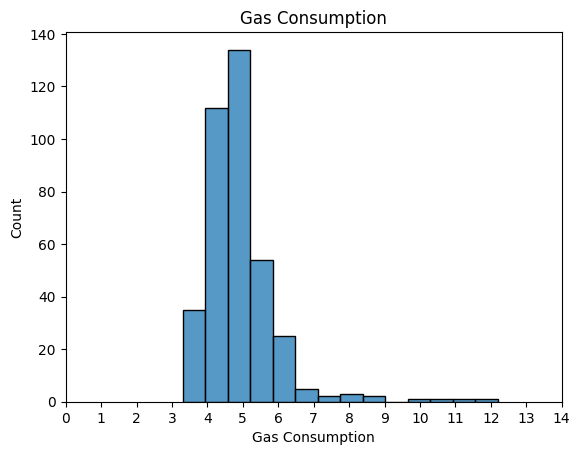

In [23]:
p1 = sns.histplot(data=df, x='consume', bins=14)
p1.set_xlabel('Gas Consumption')
p1.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
p1.set_title('Gas Consumption')
plt.show()

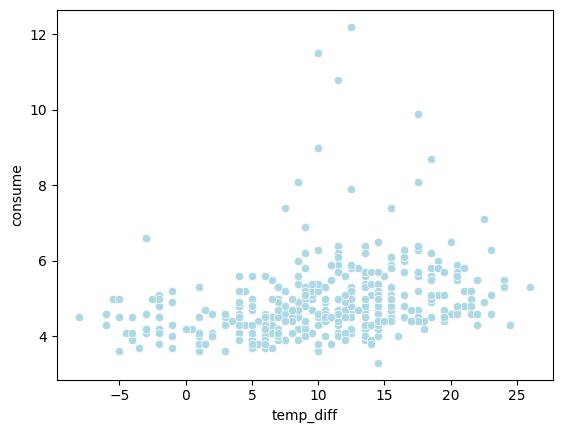

In [24]:
sns.scatterplot(data=df, x ='temp_diff', y ='consume', color='lightblue')
plt.show()

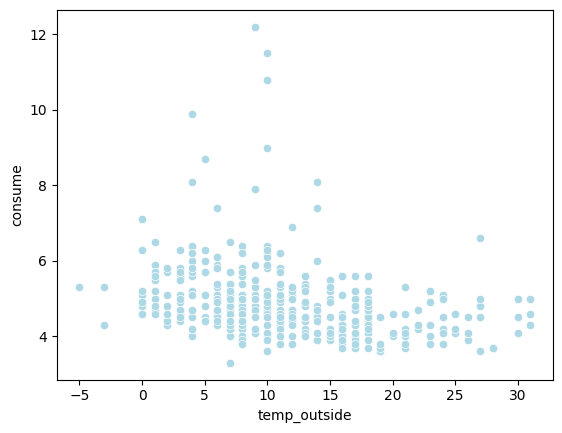

In [25]:
sns.scatterplot(data=df, x ='temp_outside', y ='consume', color='lightblue')
plt.show()

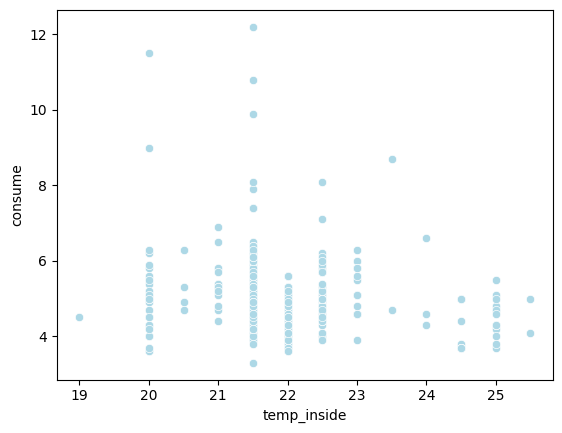

In [26]:
sns.scatterplot(data=df, x ='temp_inside', y ='consume', color='lightblue')
plt.show()

In [27]:
# Regression with Lasso

In [28]:
dummies = pd.get_dummies(df['gas_type'])

In [29]:
df = pd.concat([df,dummies],axis=1)

In [30]:
df

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,temp_diff,E10,SP98
0,28.0,5.0,26,21.5,12,E10,0,0,0,9.5,True,False
1,12.0,4.2,30,21.5,13,E10,0,0,0,8.5,True,False
2,11.2,5.5,38,21.5,15,E10,0,0,0,6.5,True,False
3,12.9,3.9,36,21.5,14,E10,0,0,0,7.5,True,False
4,18.5,4.5,46,21.5,15,E10,0,0,0,6.5,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,39,24.5,18,SP98,0,0,0,6.5,False,True
384,16.1,4.3,38,25.0,31,SP98,1,0,0,-6.0,False,True
385,16.0,3.8,45,25.0,19,SP98,0,0,0,6.0,False,True
386,15.4,4.6,42,25.0,31,SP98,1,0,0,-6.0,False,True


In [31]:
X = df[['distance','speed','temp_inside','temp_outside','AC','rain','sun','temp_diff','E10','SP98']]

In [32]:
Y = df['consume']

In [33]:
scaler = StandardScaler()

In [34]:
X = scaler.fit_transform(X)

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state=129)

In [36]:
lasso = Lasso()

In [37]:
lasso.fit(X_train,Y_train)

Lasso()

In [38]:
Y_pred = lasso.predict(X_test)

In [39]:
abs(Y_pred-Y_test).mean()

0.5909084050098083

In [40]:
# XG Boost

In [41]:
xgb_model = XGBRegressor()

In [42]:
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [43]:
Y_pred = xgb_model.predict(X_test)

In [44]:
abs(Y_pred-Y_test).mean()

0.4625245281990539

In [45]:
# Findings

In [ ]:
"""
The car company has so far utilized more SP98 than E10 measured in total distance. Although the company believes that going
green will cost more, the EDA above shows that the difference in gas consumption between the two is minimal and is more likely
influenced by other factors, such as difference between inside and outside temperature and AC usage.

I trained two supervised machine learning regression models, the Lasso regression and XG Boost, to predict gas consumption 
based on all the other columns in the dataset. The decent Mean Absolute Error of the model indicates that the data does possess 
predictive potential.

"""